In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2026-01-01 09:42:47.044803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767260567.363449      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767260567.444544      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ All libraries imported successfully!
TensorFlow version: 2.18.0
GPU Available: []


2026-01-01 09:43:07.261966: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
train_dir = '/kaggle/input/brain-tumor-dataset/Training'  
test_dir = '/kaggle/input/brain-tumor-dataset/Testing'   

# CRITICAL FIX: Sort classes to ensure consistent ordering across all operations
CLASSES = sorted(os.listdir(train_dir))
IMAGE_SIZE = 128  # Image dimensions for model input

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"Training directory: {train_dir}")
print(f"Testing directory: {test_dir}")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"\nClasses (in order): {CLASSES}")
print(f"Number of classes: {len(CLASSES)}")
print("=" * 70)

# Verify directories exist
if not os.path.exists(train_dir):
    print("⚠️  ERROR: Training directory not found!")
    print("Please update train_dir path to match your Kaggle dataset")
else:
    print("✓ Training directory found")
    
if not os.path.exists(test_dir):
    print("⚠️  ERROR: Testing directory not found!")
    print("Please update test_dir path to match your Kaggle dataset")
else:
    print("✓ Testing directory found")

CONFIGURATION
Training directory: /kaggle/input/brain-tumor-dataset/Training
Testing directory: /kaggle/input/brain-tumor-dataset/Testing
Image size: 128x128

Classes (in order): ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4
✓ Training directory found
✓ Testing directory found


In [6]:
def load_dataset(data_dir):
    """Load image paths and labels from directory structure"""
    paths = []
    labels = []
    
    for label in CLASSES:  # Use sorted CLASSES, not os.listdir()
        label_path = os.path.join(data_dir, label)
        if not os.path.exists(label_path):
            print(f"⚠️  Warning: {label_path} not found")
            continue
            
        images = os.listdir(label_path)
        for image in images:
            if image.lower().endswith(('.jpg', '.jpeg', '.png')):  # Only image files
                paths.append(os.path.join(label_path, image))
                labels.append(label)
    
    return paths, labels

# Load training data
print("Loading training data...")
train_paths, train_labels = load_dataset(train_dir)
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

# Load testing data
print("Loading testing data...")
test_paths, test_labels = load_dataset(test_dir)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

print("\n" + "=" * 70)
print("DATASET SUMMARY")
print("=" * 70)
print(f"Training samples: {len(train_paths)}")
print(f"Testing samples: {len(test_paths)}")
print(f"\nClass distribution (Training):")
for cls in CLASSES:
    count = train_labels.count(cls)
    print(f"  {cls:15s}: {count:5d} images ({count/len(train_labels)*100:.1f}%)")
print("=" * 70)

Loading training data...
Loading testing data...

DATASET SUMMARY
Training samples: 5712
Testing samples: 1311

Class distribution (Training):
  glioma         :  1321 images (23.1%)
  meningioma     :  1339 images (23.4%)
  notumor        :  1595 images (27.9%)
  pituitary      :  1457 images (25.5%)


Displaying sample images...


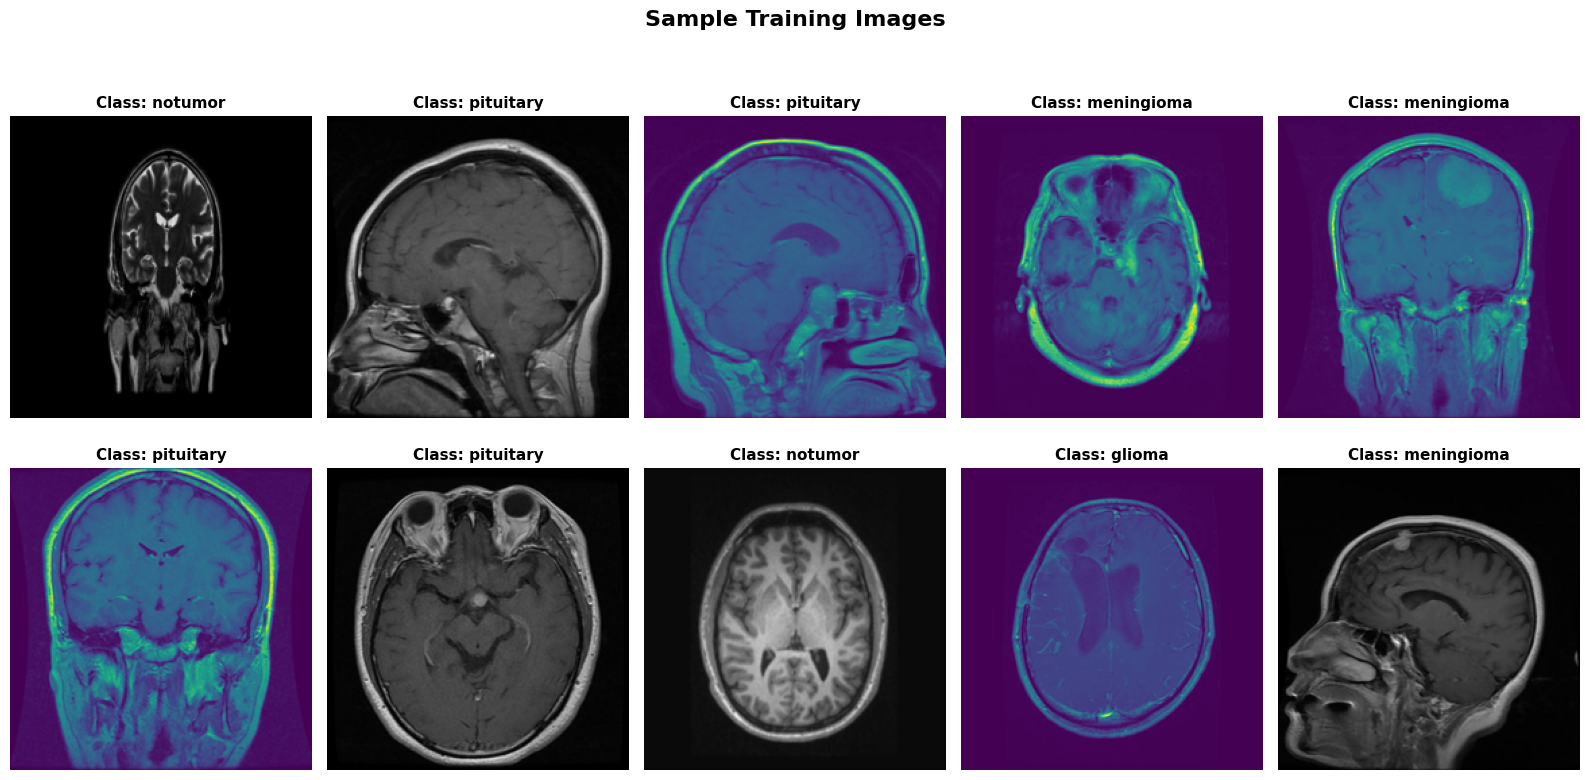

✓ Sample images displayed and saved as 'sample_images.png'


In [7]:
# Select 10 random training images to display
num_samples = min(10, len(train_paths))
random_indices = random.sample(range(len(train_paths)), num_samples)

fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

print("Displaying sample images...")
for i, idx in enumerate(random_indices):
    # Load and resize image
    img = Image.open(train_paths[idx])
    img = img.resize((224, 224))
    
    # Display
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Class: {train_labels[idx]}", fontsize=11, fontweight='bold')

plt.suptitle("Sample Training Images", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample images displayed and saved as 'sample_images.png'")

In [9]:

def augment_image(image):
    
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def load_images(paths, augment=True):
   
    images = []
    for path in paths:
        # Load image
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)
        
        # Apply augmentation for training, just normalize for testing
        if augment:
            image = augment_image(image)
        else:
            image = image / 255.0  # Just normalize, no augmentation
        
        images.append(image)
    
    return np.array(images)

def encode_labels(labels):
   
    encoded = [CLASSES.index(label) for label in labels]
    return np.array(encoded)

def data_generator(paths, labels, batch_size=20, epochs=1, augment=True):
    """
    Generator function for batch training
    Yields batches of images and labels
    """
    for epoch in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            # Load and preprocess batch
            batch_images = load_images(batch_paths, augment=augment)
            batch_labels_encoded = encode_labels(batch_labels)
            
            yield batch_images, batch_labels_encoded

print("✓ Data preprocessing functions defined")
print(f"  - augment_image: Applies random brightness/contrast")
print(f"  - load_images: Loads and normalizes images")
print(f"  - encode_labels: Converts class names to integers (FIXED)")
print(f"  - data_generator: Yields batches for training")

✓ Data preprocessing functions defined
  - augment_image: Applies random brightness/contrast
  - load_images: Loads and normalizes images
  - encode_labels: Converts class names to integers (FIXED)
  - data_generator: Yields batches for training


In [10]:

print("Building model architecture...")
print("-" * 70)

# Load VGG16 pre-trained on ImageNet (without top classification layer)
base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

print("✓ VGG16 base model loaded")

# Freeze early layers (they already know basic features like edges, colors)
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Unfreeze last 4 layers (let them adapt to MRI images)
for layer in base_model.layers[-4:]:
    layer.trainable = True

print(f"✓ Frozen layers: {len([l for l in base_model.layers if not l.trainable])}")
print(f"✓ Trainable layers: {len([l for l in base_model.layers if l.trainable])}")

# Build complete model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,                              # VGG16 feature extractor
    Flatten(),                                # Flatten 2D features to 1D
    Dropout(0.3),                            # Regularization (30% dropout)
    Dense(128, activation='relu'),            # Hidden layer
    Dropout(0.2),                            # More regularization
    Dense(len(CLASSES), activation='softmax') # Output layer (4 classes)
])

# Compile model with optimizer and loss function
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print("-" * 70)
print("MODEL SUMMARY:")
print("-" * 70)
model.summary()
print("-" * 70)
print(f"✓ Model compiled successfully")
print(f"  - Total parameters: {model.count_params():,}")
print(f"  - Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"  - Output classes: {len(CLASSES)}")

Building model architecture...
----------------------------------------------------------------------
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✓ VGG16 base model loaded
✓ Frozen layers: 15
✓ Trainable layers: 4
----------------------------------------------------------------------
MODEL SUMMARY:
----------------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

----------------------------------------------------------------------
✓ Model compiled successfully
  - Total parameters: 15,763,908
  - Trainable parameters: 8,128,644
  - Output classes: 4


In [11]:
# Training hyperparameters
BATCH_SIZE = 20
EPOCHS = 5
steps_per_epoch = len(train_paths) // BATCH_SIZE

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total batches: {steps_per_epoch * EPOCHS}")
print(f"Estimated time: 2-3 hours")
print("=" * 70)

# Train the model
history = model.fit(
    data_generator(train_paths, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, augment=True),
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

print("\n" + "=" * 70)
print("✓ TRAINING COMPLETE!")
print("=" * 70)

# Display final training metrics
final_acc = history.history['sparse_categorical_accuracy'][-1]
final_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {final_acc*100:.2f}%")
print(f"Final Training Loss: {final_loss:.4f}")

STARTING TRAINING
Batch size: 20
Epochs: 5
Steps per epoch: 285
Total batches: 1425
Estimated time: 2-3 hours
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - loss: 0.6382 - sparse_categorical_accuracy: 0.7402
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - loss: 0.2429 - sparse_categorical_accuracy: 0.9077
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9431
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9661
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9696

✓ TRAINING COMPLETE!
Final Training Accuracy: 97.31%
Final Training Loss: 0.0793


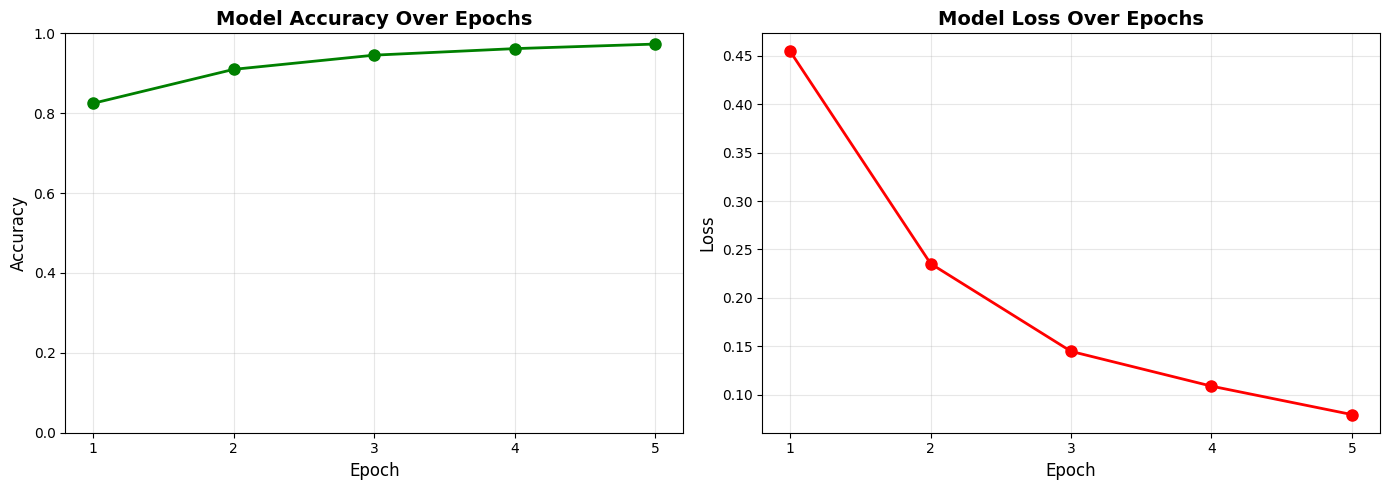

✓ Training history saved as 'training_history.png'

Training Summary:
  Starting Accuracy: 82.49%
  Final Accuracy: 97.31%
  Improvement: 14.82%


In [12]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history.history['sparse_categorical_accuracy'], 'o-g', linewidth=2, markersize=8)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xticks(range(EPOCHS))
ax1.set_xticklabels(range(1, EPOCHS+1))
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot loss
ax2.plot(history.history['loss'], 'o-r', linewidth=2, markersize=8)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xticks(range(EPOCHS))
ax2.set_xticklabels(range(1, EPOCHS+1))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history saved as 'training_history.png'")
print(f"\nTraining Summary:")
print(f"  Starting Accuracy: {history.history['sparse_categorical_accuracy'][0]*100:.2f}%")
print(f"  Final Accuracy: {history.history['sparse_categorical_accuracy'][-1]*100:.2f}%")
print(f"  Improvement: {(history.history['sparse_categorical_accuracy'][-1] - history.history['sparse_categorical_accuracy'][0])*100:.2f}%")

In [13]:

print("=" * 70)
print("EVALUATING MODEL ON TEST SET")
print("=" * 70)

# Load test images (NO augmentation for testing!)
print("Loading test images...")
test_images = load_images(test_paths, augment=False)
test_labels_encoded = encode_labels(test_labels)

print(f"Test images loaded: {test_images.shape}")
print("Making predictions...")

# Get predictions
test_predictions = model.predict(test_images, verbose=1)
predicted_classes = np.argmax(test_predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_classes == test_labels_encoded)

print("\n" + "=" * 70)
print(f"TEST ACCURACY: {accuracy*100:.2f}%")
print("=" * 70)

# Detailed classification report
print("\nCLASSIFICATION REPORT:")
print("-" * 70)
print(classification_report(
    test_labels_encoded,
    predicted_classes,
    target_names=CLASSES,
    digits=4
))

EVALUATING MODEL ON TEST SET
Loading test images...
Test images loaded: (1311, 128, 128, 3)
Making predictions...
41/41 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step

TEST ACCURACY: 95.73%

CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

      glioma     0.9672    0.8833    0.9233       300
  meningioma     0.8892    0.9444    0.9160       306
     notumor     0.9902    0.9975    0.9938       405
   pituitary     0.9770    0.9900    0.9834       300

    accuracy                         0.9573      1311
   macro avg     0.9559    0.9538    0.9542      1311
weighted avg     0.9583    0.9573    0.9572      1311



Confusion Matrix:
[[265  34   0   1]
 [  8 289   3   6]
 [  1   0 404   0]
 [  0   2   1 297]]

Note: High numbers on the diagonal = good predictions!


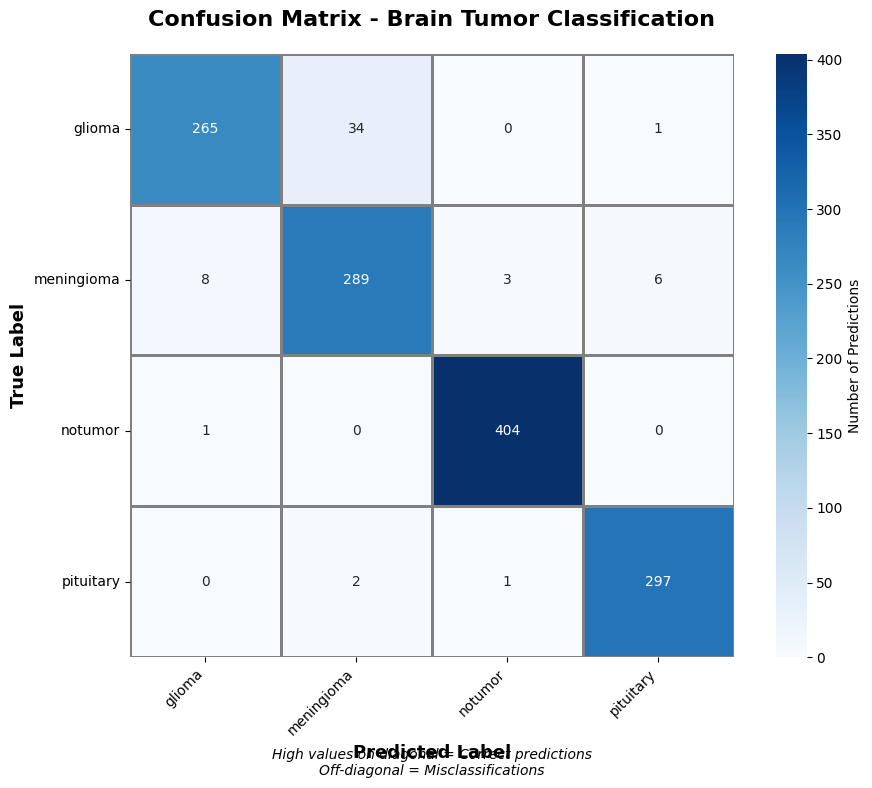


Per-Class Accuracy:
----------------------------------------
glioma         :  88.33% (265/300)
meningioma     :  94.44% (289/306)
notumor        :  99.75% (404/405)
pituitary      :  99.00% (297/300)


In [14]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("\nNote: High numbers on the diagonal = good predictions!")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cbar_kws={'label': 'Number of Predictions'},
    square=True,
    linewidths=1,
    linecolor='gray'
)

plt.title("Confusion Matrix - Brain Tumor Classification", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=13, fontweight='bold')
plt.ylabel("True Label", fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add text explanation
textstr = "High values on diagonal = Correct predictions\nOff-diagonal = Misclassifications"
plt.text(0.5, -0.15, textstr, ha='center', va='top', 
         transform=plt.gca().transAxes, fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i, cls in enumerate(CLASSES):
    class_correct = conf_matrix[i, i]
    class_total = conf_matrix[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{cls:15s}: {class_acc*100:6.2f}% ({class_correct}/{class_total})")

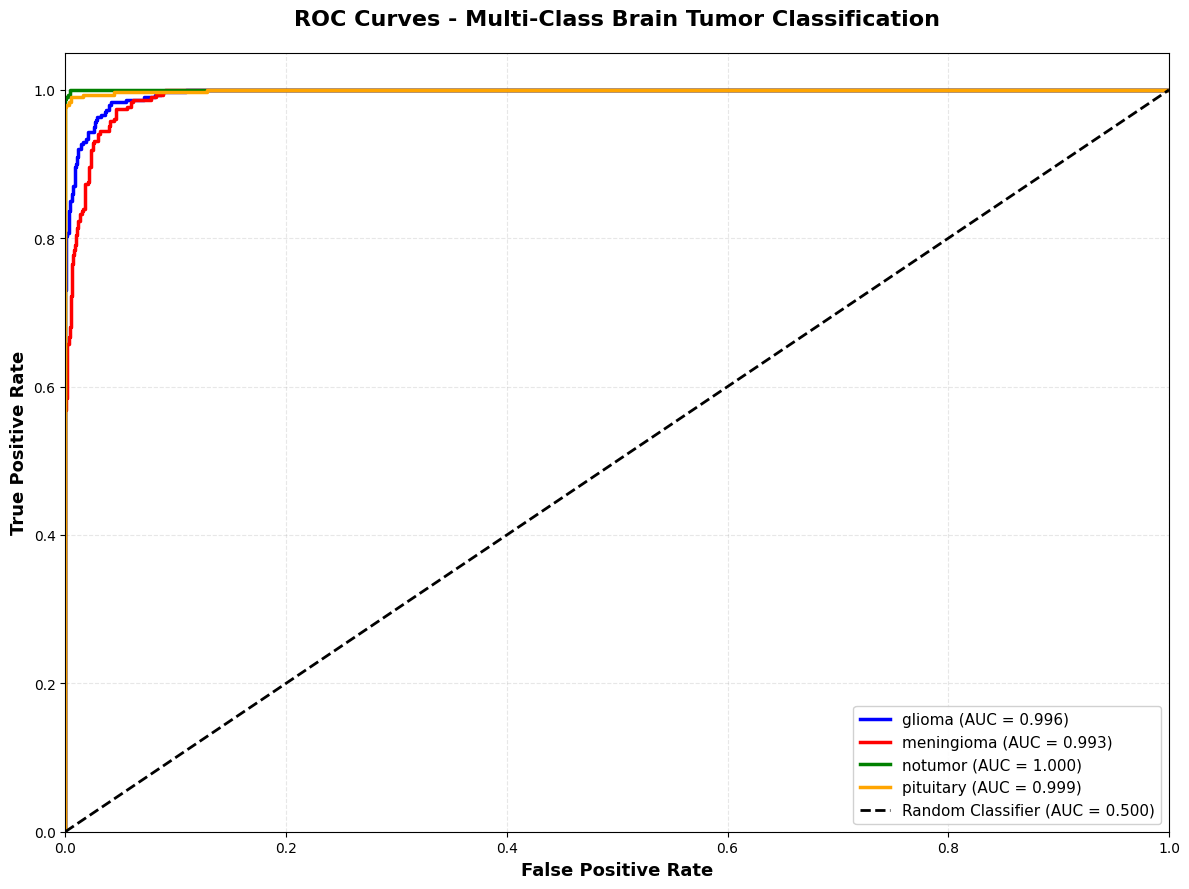


AUC Scores Summary:
----------------------------------------
glioma         : 0.9961
meningioma     : 0.9930
notumor        : 1.0000
pituitary      : 0.9993
Average        : 0.9971

Note: AUC > 0.9 = Excellent, > 0.8 = Good, > 0.7 = Fair


In [15]:

# Binarize labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=range(len(CLASSES)))

# Plot ROC curve for each class
plt.figure(figsize=(12, 9))

colors = ['blue', 'red', 'green', 'orange', 'purple']
auc_scores = []

for i, class_name in enumerate(CLASSES):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    # Plot
    plt.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2.5,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - Multi-Class Brain Tumor Classification', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print AUC summary
print("\nAUC Scores Summary:")
print("-" * 40)
for cls, score in zip(CLASSES, auc_scores):
    print(f"{cls:15s}: {score:.4f}")
print(f"{'Average':15s}: {np.mean(auc_scores):.4f}")
print("\nNote: AUC > 0.9 = Excellent, > 0.8 = Good, > 0.7 = Fair")

In [16]:
# Save the trained model in Keras 3 format
model_filename = 'brain_tumor_model.keras'  # <-- updated extension
model.save(model_filename)
print(f"✓ Model saved as '{model_filename}'")

# Save class order (critical for future predictions!)
class_order_filename = 'class_order.txt'
with open(class_order_filename, 'w') as f:
    for cls in CLASSES:
        f.write(f"{cls}\n")
print(f"✓ Class order saved as '{class_order_filename}'")

# Save training configuration
config_filename = 'model_config.txt'
with open(config_filename, 'w') as f:
    f.write(f"Model Configuration\n")
    f.write("=" * 50 + "\n")
    f.write(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}\n")
    f.write(f"Batch Size: {BATCH_SIZE}\n")
    f.write(f"Epochs: {EPOCHS}\n")
    f.write(f"Classes: {', '.join(CLASSES)}\n")
    f.write(f"Training Samples: {len(train_paths)}\n")
    f.write(f"Testing Samples: {len(test_paths)}\n")
    f.write(f"Final Training Accuracy: {final_acc*100:.2f}%\n")
    f.write(f"Test Accuracy: {accuracy*100:.2f}%\n")
print(f"✓ Configuration saved as '{config_filename}'")

# Optional: print summary of saved files
print("\n" + "=" * 70)
print("FILES SAVED:")
print("=" * 70)
print(f"  1. {model_filename} - Trained model (Keras 3 format)")
print(f"  2. {class_order_filename} - Class mapping")
print(f"  3. {config_filename} - Training configuration")
print(f"  4. sample_images.png - Sample training data")
print(f"  5. training_history.png - Training progress")
print(f"  6. confusion_matrix.png - Model performance")
print(f"  7. roc_curves.png - ROC analysis")
print("=" * 70)


✓ Model saved as 'brain_tumor_model.keras'
✓ Class order saved as 'class_order.txt'
✓ Configuration saved as 'model_config.txt'

FILES SAVED:
  1. brain_tumor_model.keras - Trained model (Keras 3 format)
  2. class_order.txt - Class mapping
  3. model_config.txt - Training configuration
  4. sample_images.png - Sample training data
  5. training_history.png - Training progress
  6. confusion_matrix.png - Model performance
  7. roc_curves.png - ROC analysis


In [17]:

def predict_tumor(image_path, model_path='brain_tumor_model.keras', show_plot=True):
    """
    Predict tumor type from MRI image
    
    Args:
        image_path: Path to MRI image
        model_path: Path to saved model (default: 'brain_tumor_model.keras)
        show_plot: Whether to display image with prediction
    
    Returns:
        predicted_class: Name of predicted class
        confidence: Confidence score (0-1)
        all_probabilities: Dictionary of all class probabilities
    """
    # Load model
    model = load_model(model_path)
    
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions)
    confidence = predictions[0][predicted_idx]
    predicted_class = CLASSES[predicted_idx]
    
    # Create probabilities dictionary
    all_probabilities = {CLASSES[i]: predictions[0][i] for i in range(len(CLASSES))}
    
    if show_plot:
        # Display result
        plt.figure(figsize=(10, 7))
        plt.imshow(load_img(image_path))
        plt.axis('off')
        
        # Determine color based on prediction
        if predicted_class == 'notumor':
            title = "✓ No Tumor Detected"
            color = 'green'
        else:
            title = f"⚠ Tumor Detected: {predicted_class.upper()}"
            color = 'red'
        
        plt.title(f"{title}\nConfidence: {confidence*100:.2f}%", 
                  fontsize=16, fontweight='bold', color=color, pad=20)
        
        # Add probability bars
        prob_text = "Class Probabilities:\n" + "-" * 30 + "\n"
        for cls, prob in sorted(all_probabilities.items(), key=lambda x: x[1], reverse=True):
            prob_text += f"{cls:12s}: {prob*100:5.2f}%\n"
        
        plt.text(0.02, 0.98, prob_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round',
                facecolor='wheat', alpha=0.8), family='monospace')
        
        plt.tight_layout()
        plt.show()
    
    return predicted_class, confidence, all_probabilities

print("✓ Prediction function defined")
print("\nUsage:")
print("  predicted_class, confidence, probs = predict_tumor('path/to/image.jpg')")

✓ Prediction function defined

Usage:
  predicted_class, confidence, probs = predict_tumor('path/to/image.jpg')


TESTING PREDICTIONS ON SAMPLE TEST IMAGES

Test Image 1/5
Image path: /kaggle/input/brain-tumor-dataset/Testing/glioma/Te-gl_0054.jpg
True label: glioma


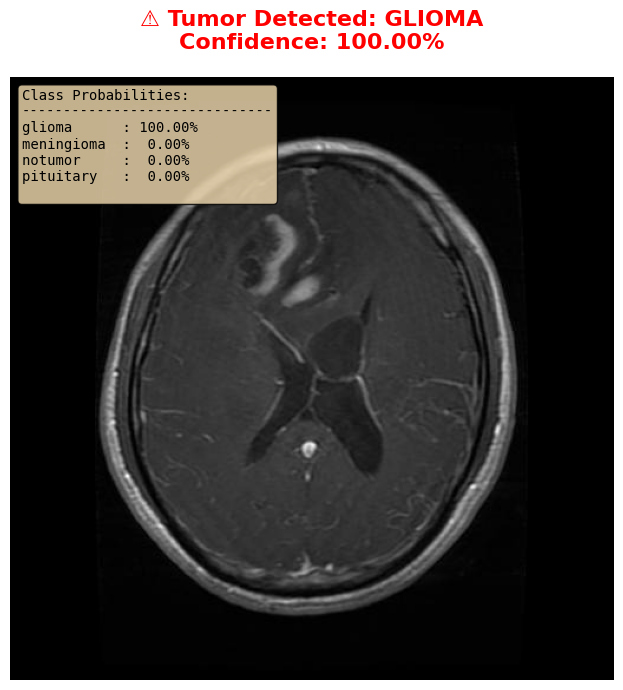


Predicted: glioma
Confidence: 100.00%
✓ CORRECT PREDICTION!

All Class Probabilities:
  glioma      : ██████████████████████████████████████████████████ 100.00%
  meningioma  :   0.00%
  notumor     :   0.00%
  pituitary   :   0.00%

Test Image 2/5
Image path: /kaggle/input/brain-tumor-dataset/Testing/pituitary/Te-pi_0076.jpg
True label: pituitary


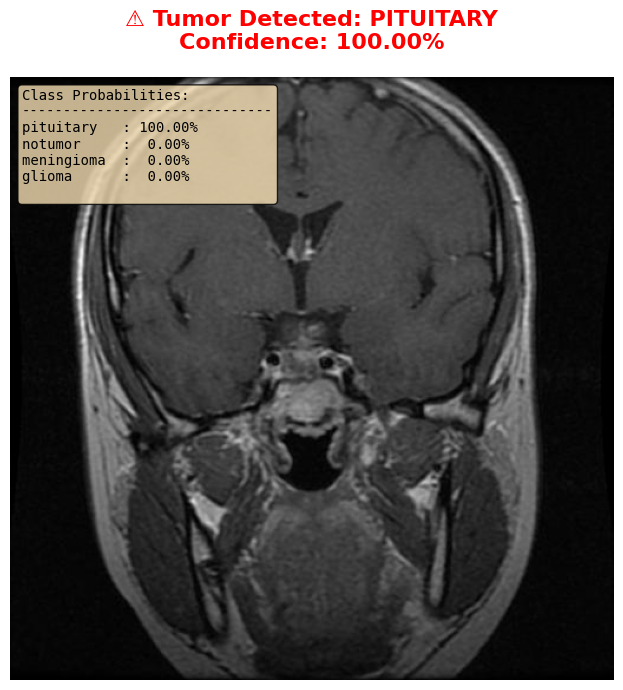


Predicted: pituitary
Confidence: 100.00%
✓ CORRECT PREDICTION!

All Class Probabilities:
  pituitary   : █████████████████████████████████████████████████ 100.00%
  notumor     :   0.00%
  meningioma  :   0.00%
  glioma      :   0.00%

Test Image 3/5
Image path: /kaggle/input/brain-tumor-dataset/Testing/meningioma/Te-me_0216.jpg
True label: meningioma


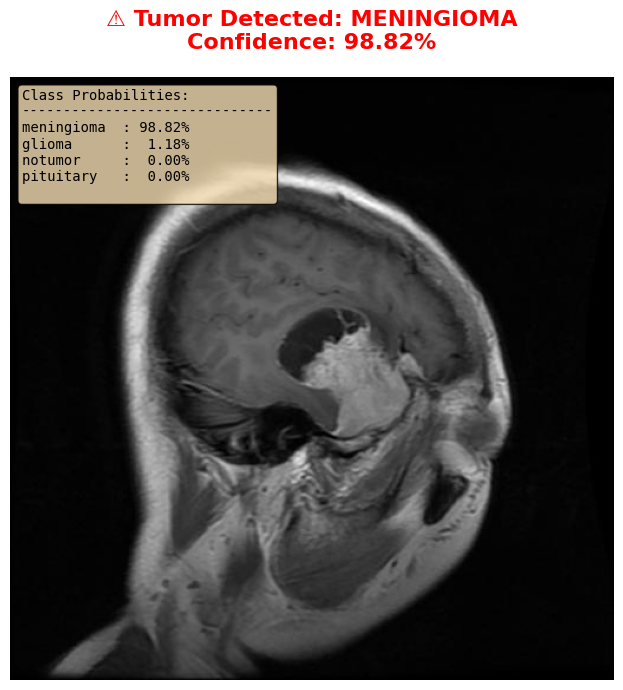


Predicted: meningioma
Confidence: 98.82%
✓ CORRECT PREDICTION!

All Class Probabilities:
  meningioma  : █████████████████████████████████████████████████ 98.82%
  glioma      :   1.18%
  notumor     :   0.00%
  pituitary   :   0.00%

Test Image 4/5
Image path: /kaggle/input/brain-tumor-dataset/Testing/notumor/Te-no_0225.jpg
True label: notumor


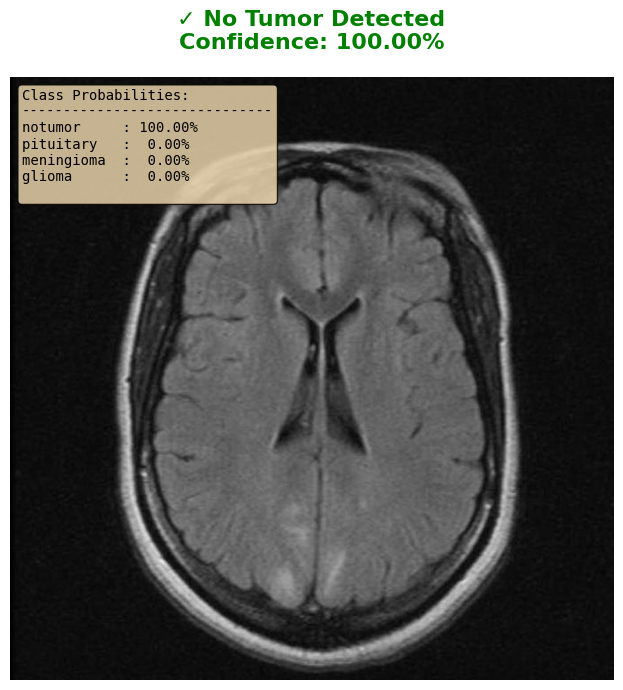


Predicted: notumor
Confidence: 100.00%
✓ CORRECT PREDICTION!

All Class Probabilities:
  notumor     : █████████████████████████████████████████████████ 100.00%
  pituitary   :   0.00%
  meningioma  :   0.00%
  glioma      :   0.00%

Test Image 5/5
Image path: /kaggle/input/brain-tumor-dataset/Testing/meningioma/Te-me_0010.jpg
True label: meningioma


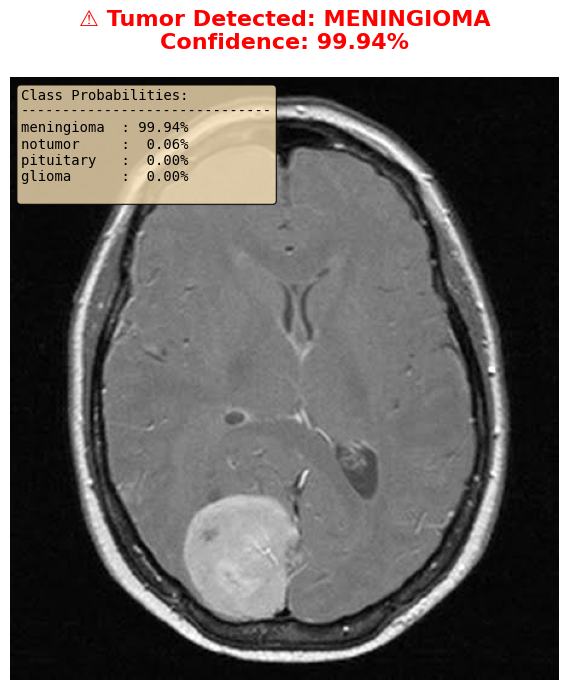


Predicted: meningioma
Confidence: 99.94%
✓ CORRECT PREDICTION!

All Class Probabilities:
  meningioma  : █████████████████████████████████████████████████ 99.94%
  notumor     :   0.06%
  pituitary   :   0.00%
  glioma      :   0.00%

Sample Test Accuracy: 5/5 (100.0%)


In [19]:
print("=" * 70)
print("TESTING PREDICTIONS ON SAMPLE TEST IMAGES")
print("=" * 70)

# Test on 5 random test images
num_test_samples = min(5, len(test_paths))
test_indices = random.sample(range(len(test_paths)), num_test_samples)

correct_predictions = 0

for i, idx in enumerate(test_indices):
    print(f"\n{'='*70}")
    print(f"Test Image {i+1}/{num_test_samples}")
    print(f"{'='*70}")
    print(f"Image path: {test_paths[idx]}")
    print(f"True label: {test_labels[idx]}")
    
    # Predict
    predicted_class, confidence, all_probs = predict_tumor(test_paths[idx], show_plot=True)
    
    print(f"\nPredicted: {predicted_class}")
    print(f"Confidence: {confidence*100:.2f}%")
    
    # Check if correct
    if predicted_class == test_labels[idx]:
        print("✓ CORRECT PREDICTION!")
        correct_predictions += 1
    else:
        print("✗ INCORRECT PREDICTION")
    
    print("\nAll Class Probabilities:")
    for cls, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
        bar = '█' * int(prob * 50)
        print(f"  {cls:12s}: {bar} {prob*100:5.2f}%")

print(f"\n{'='*70}")
print(f"Sample Test Accuracy: {correct_predictions}/{num_test_samples} ({correct_predictions/num_test_samples*100:.1f}%)")
print(f"{'='*70}")


Testing Image 1/3


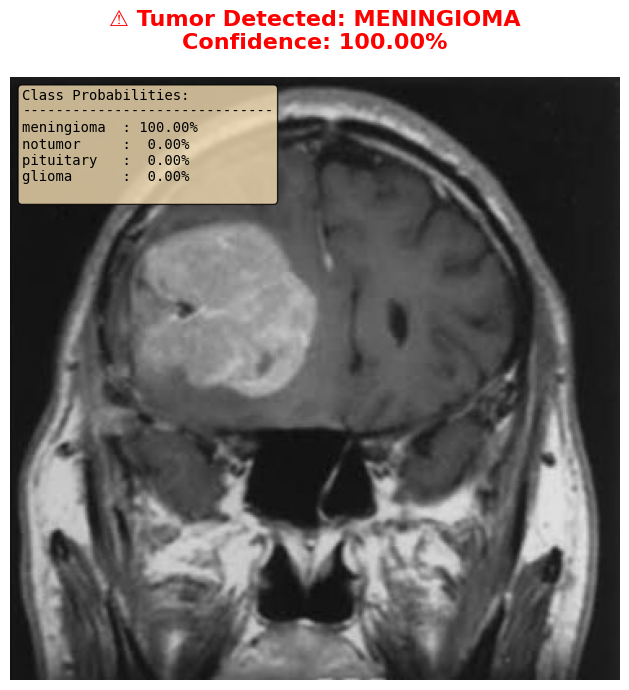

Predicted: meningioma
Confidence: 100.00%

All Class Probabilities:
  meningioma  : █████████████████████████████████████████████████ 100.00%
  notumor     :   0.00%
  pituitary   :   0.00%
  glioma      :   0.00%

Testing Image 2/3


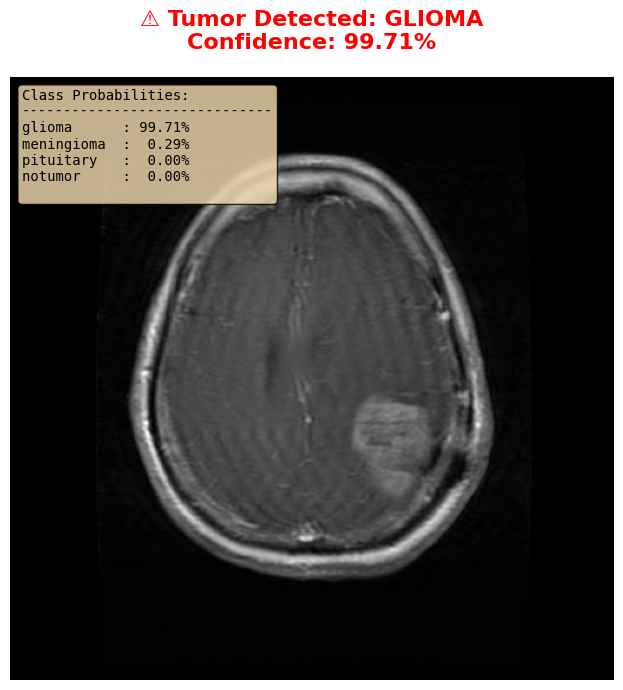

Predicted: glioma
Confidence: 99.71%

All Class Probabilities:
  glioma      : █████████████████████████████████████████████████ 99.71%
  meningioma  :   0.29%
  pituitary   :   0.00%
  notumor     :   0.00%

Testing Image 3/3


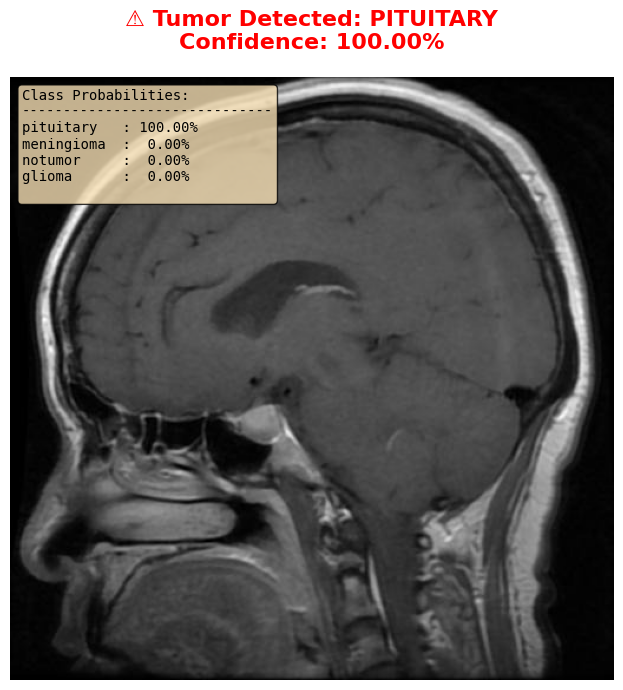

Predicted: pituitary
Confidence: 100.00%

All Class Probabilities:
  pituitary   : █████████████████████████████████████████████████ 100.00%
  meningioma  :   0.00%
  notumor     :   0.00%
  glioma      :   0.00%


In [21]:
image_paths = [
    r"/kaggle/input/brain-tumor-dataset/Testing/meningioma/Te-me_0021.jpg",
    r"/kaggle/input/brain-tumor-dataset/Testing/glioma/Te-gl_0023.jpg",
    r"/kaggle/input/brain-tumor-dataset/Testing/pituitary/Te-piTr_0003.jpg"
]

for i, image_path in enumerate(image_paths):
    print(f"\n{'='*70}")
    print(f"Testing Image {i+1}/{len(image_paths)}")
    print(f"{'='*70}")

    predicted_class, confidence, all_probs = predict_tumor(
        image_path,
        show_plot=True
    )

    print(f"Predicted: {predicted_class}")
    print(f"Confidence: {confidence * 100:.2f}%")

    print("\nAll Class Probabilities:")
    for cls, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
        bar = '█' * int(prob * 50)
        print(f"  {cls:12s}: {bar} {prob*100:5.2f}%")